やりたいこと

・引ける牌の確率が変わったとき（手牌にある牌はその分引きづらくなるとか）のvalueを求める

・18種や27種（マンズだけでなく、ピンズやソーズも増やす）時のvalueを求める

面倒なので、まずは最大でも１色とする(n<=9)、手牌は14枚以下(m=3, 5, 8, 11, 14のみ)、同一牌は4枚(l = 4)でこれは固定。この条件でvalueを求める。



 **変数の意味**

- state : あがりに必要な枚数の手牌の状態

- hand : stateから一枚切った状態

### 必要な関数の再定義

In [1]:
from collections import defaultdict
def is_valid(seq, l=4): # 生成された組み合わせが手牌として妥当かどうかを判断する関数　tuple(seq)の一つ一つが一つの状態(手牌)に対応している
    counts = defaultdict(lambda: 0)
    for i in range(0, len(seq)):
        if i + 1 < len(seq) and seq[i] > seq[i + 1]: # 前半の条件はiが一番最後以外は常に成立、後半の条件は昇順に整列するための条件
            return False
        counts[seq[i]] += 1
        if (counts[seq[i]] > l): return False # 牌の上限枚数を超えたらFalse
    return True

import itertools
def number_state_slow(n,m,l): # 全ての手牌の組み合わせの数を出力する関数
    count = 0
    for seq in itertools.product(range(n), repeat = m): # 直積を作る関数, n=9 m=5 なら 9 ** 5 回繰り返す　
        if is_valid(seq,l):
            count += 1
            #print(list(seq))
    return count
    
def generate_all_l(n, m, l=4): # 全ての手牌の組み合わせをタプルで出力する関数
    gen_list = []
    for seq in itertools.product(range(n), repeat = m):
        if is_valid(seq, l):
            gen_list.append(seq)
    return gen_list

def states_to_hist(state_list, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist_list = []
    for state in state_list:
        #print(state)
        ret = [0] * n # ret = [0,0,...,0]
        for c in state:
            ret[c] += 1
        hist_list.append(ret)
    return hist_list

def hand_to_prob_and_state(hand, state_nml, n, m, l=4): # ある手牌(hand)における、1枚ツモる時の遷移確率(prob)と手牌(state)のindexのタプルを出す関数
    #print(state_nml)
    ret = [l] * n  #  残り枚数を表すリスト
    for h in hand:
        ret[h] -= 1
    yama_sum = n * l - (m - 1)
    state_list = []
    for i in range(n):
        if ret[i] == 0: 
            continue
        prob = ret[i] / yama_sum # 遷移確率
        state = tuple(sorted(list(hand) + [i])) # 遷移後の手牌
        #print(state)
        state_index = state_nml.index(state) # 遷移後の手牌のindex
        #print(state_index)
        state_list.append((prob, state_index))
    return state_list

def state_to_hand(state): # ある手牌stateに遷移できるhandを出力する関数
    return list(set(tuple(state[:i] + state[i+1:]) for i in range(len(state)))) # i番目の要素を取り除く

def is_win_sub(hist, two, three):
    if any(x < 0 for x in hist):
        return False # この行を消したかったら、順子判定のところで手牌の枚数が負になるものを弾いておく
    if two == 0 and three == 0:
        return True
    i = next(i for i, x in enumerate(hist) if x > 0) # histの中でx>０を満たす最小のindexを持ってくる
    if two > 0 and hist[i] >= 2 and is_win_sub([x - 2 if i == j else x for j, x in enumerate(hist)], two - 1, three): # 雀頭
        return True
    if three > 0 and hist[i] >= 3 and is_win_sub([x - 3 if i == j else x for j, x in enumerate(hist)], two, three - 1): # 刻子
        return True
    if three > 0 and i + 2 < len(hist) and is_win_sub([x -1 if i <= j <= i + 2 else x for j, x in enumerate(hist)], two, three - 1): # 順子
        return True
    return False

def is_win_main(hist):
    n_two = 1 if sum(hist) % 3 == 2 else 0
    n_three = sum(hist) // 3
    return is_win_sub(hist, n_two, n_three)

def value_iteration(n, m, l, gamma):
    state_nml = generate_all_l(n, m, l)
    hand_nml = generate_all_l(n, m-1, l)
    hist_nml = states_to_hist(state_nml, n)
    is_win_nml = [is_win_main(hist) for hist in hist_nml]
    h2ps_nml = [hand_to_prob_and_state(hand, state_nml, n, m, l) for hand in hand_nml]
    s2h_nml = [[hand_nml.index(hand) for hand in state_to_hand(state)] for state in state_nml]
    value_hand = [0] * len(hand_nml)
    n_hand = len(hand_nml)
    value_state = [1 if is_win_nml[i] else 0 for i in range(len(state_nml))] # あがっていればvalueは1、いなければ0
    n_state = len(state_nml)
    theta = 1e-6
    while True:
        print('iteration')
        delta = 0
        for i in range(n_hand):
            old_v = value_hand[i]
            value_hand[i] = sum(p * value_state[n] for (p, n) in h2ps_nml[i])
            delta = max(delta, abs(old_v - value_hand[i]))
        if delta < theta: break
        for i in range(n_state):
            if is_win_nml[i]: continue
            value_state[i] = max(gamma * value_hand[n] for n in s2h_nml[i])
    return value_hand

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import time

random_seed = 34
np.random.seed(random_seed)
#tf.set_random_seed(random_seed)

In [3]:
def one_hot_vector1(hands, n): # 手牌の中の牌一つ一つをone-hotにした(手牌１つがn * m-1の行列に対応)
    results = np.zeros((len(hands), n, len(hands[0])))
    for i in range(len(hands)):
        for j, hand_i in enumerate(hands[i]):
            results[i][hand_i][j] = 1
    return results

def one_hot_vector2(hists, n, l=4): # histをそのままone-hotにした(手牌１つがn * l + 1の行列に対応)
    results = np.zeros((len(hists), n, l + 1))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            results[i][j][hist_i] = 1
    return results

def one_hot_vector3(hists, n, l=4): # 上に近いけど、持ってる枚数より小さい数も1で埋めた(手牌１つがn * lの行列に対応)
    results = np.zeros((len(hists), n, l))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            if hist_i == 0:
                continue
            else:
                results[i][j][:hist_i] = 1
    return results

### 捨て牌ベクトルの作成

In [4]:
n = 9
m = 5
l = 4

value_hand_nml = value_iteration(n, m, l, 0.9)
state_nml = generate_all_l(n, m, l)
hand_nml = generate_all_l(n, m - 1, l)
#print(len(hand_nml))
#print(hand_nml)
#print(value_hand_nml)

def state_to_hist(state, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist = [0] * n # hist = [0,0,...,0]
    for c in state:
        hist[c] += 1
    return hist

# stateとその時にvalueが最大となる捨て牌のタプルを入れたリスト max_value_discard_list = [((0, 0, 0, 0, 1), {0}), ((0, 0, 0, 0, 2), {0}), ... ,((7, 8, 8, 8, 8), {8})]
# state_nmlのうち、あがり形を抜いたもの discard_state_nml = [(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), ..., (7, 8, 8, 8, 8)]
def states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l=4):
    max_value_list = []
    discard_state_nml = []
    hist_nml = states_to_hist(state_nml, n)
    for i, hist in enumerate(hist_nml):        
        if is_win_main(hist):
            continue # あがっているstateの時は何も入れない
        else:
            max_value = 0
            max_p = []
            for j in range(m):
                state = state_nml[i]
                hand = state[:j] + state[j+1:]
                ind = hand_nml.index(tuple(hand))
                hand_val = value_hand_nml[ind]
                if max_value < hand_val:
                    max_p = {state[j]}
                    max_value = hand_val
                elif round(max_value, 5) == round(hand_val, 5): # 小数点以下5桁まで同じなら同じとみなす
                    max_p.add(state[j])
            discard_state_nml.append(state_nml[i])
            max_value_list.append(tuple((state_nml[i], max_p)))
    return max_value_list, discard_state_nml # 正直discard_hist_nmlを出す方が早い

# 各stateにおいて、出力してほしい捨て牌の確率分布を出力する
def discard_ans_prob_vector(max_value_discard_list, n, m, l):
    discard_vector = []
    for i, discard in max_value_discard_list:
        v = [0] * n
        num = len(discard)
        for p in discard:
            v[p] = 1 / num # 答えの数で割った値を教師とする  こうしないと学習がうまくいかない?
            #v[p] = 1
        discard_vector.append(v)
    return discard_vector

n = 34
max_value_discard_list, discard_state_nml = states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l)
#for i in max_value_discard_list: print(i) 
discard_hist_nml = states_to_hist(discard_state_nml, n)
discard_ans_vector_nml = np.array(discard_ans_prob_vector(max_value_discard_list, n, m, l))
#print(discard_ans_vector_nml)

iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [5]:
class PrintDot(keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
        
    def on_epoch_end(self, epoch, logs):
        if epoch % (self.epochs // 5) == 0: print(logs.get('loss'))
        if epoch % 10 == 0: print('.', end='')

# discard_state_nmlをone_hot化する関数
def one_hot(discard_state_nml, num):
    if num == 1:
        return one_hot_vector1(discard_state_nml, n)
    elif num == 2:
        discard_hist_nml = states_to_hist(discard_state_nml, n)
        return one_hot_vector2(discard_hist_nml, n, l)
    else:
        discard_hist_nml = states_to_hist(discard_state_nml, n)
        return one_hot_vector3(discard_hist_nml, n, l)

# predictionsから求めた捨て牌のリストを返す関数
def make_pred_arg_list_split(predictions, discard_state_test):
    pred_arg_list = []
    for i  in range(len(predictions)):
        tile = np.argmax(predictions[i])
        if tile not in discard_state_test[i]:
            max_val = 0
            max_tile = 0
            for t in discard_state_test[i]:
                if predictions[i][t] > max_val:
                    max_val = predictions[i][t]
                    max_tile = t
            tile = max_tile
        pred_arg_list.append(tile)
    return pred_arg_list

# 正解率を返す関数
def acc_score_split(pred_arg_list, discard_state_test): 
    tr_count = 0
    fal_count = 0
    for i, pred_arg in enumerate(pred_arg_list):
        #print(i, j)
        for state, discard_set in max_value_discard_list:
            if discard_state_test[i] == state:
                if pred_arg in discard_set:
                    tr_count += 1
                else:
                    fal_count += 1
    print('true count {}  false count {}'.format(tr_count, fal_count))
    print('accuracy rate', tr_count / (tr_count + fal_count))
    return tr_count / (tr_count + fal_count)

### Policy networkの作成

In [6]:
# allFlter
def train_policy_network(num, kernel_size_list, n_trials, EPOCHS):
    start_time = time.time()
    result_mean_dict  = {}
    result_std_dict = {}
    pred_acc_dict = {}
    time_dict = {}
    plt.figure()
    
    for k_num in kernel_size_list:
        def build_model():
            model = keras.Sequential([
                layers.InputLayer(input_shape=(n, l, 1)),
                layers.Conv2D(filters=32, kernel_size=(k_num, l)),
                layers.BatchNormalization(),
                layers.Dropout(0.5),
                layers.Flatten(),
                layers.Dense(400, activation='relu'),
                layers.Dense(34, activation='softmax'),
            ])
            optimizer = keras.optimizers.Adam()
            model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
            return model

        sum_acc_result = pd.Series([0] * EPOCHS)
        final_acc_results = []
        pred_acc_results = []
        for i in range(n_trials):
            model = build_model()
            if i == 0:
                model.summary()
            discard_state_train, discard_state_test, discard_ans_vector_train, discard_ans_vector_test = train_test_split(discard_state_nml, discard_ans_vector_nml, test_size=0.25)
            #print(discard_state_train[:5])
            #print(discard_ans_vector_train[:5])
            one_hot_discard_state_train = one_hot(discard_state_train, num).reshape(len(discard_state_train), n, l, 1)
            one_hot_discard_state_test = one_hot(discard_state_test, num).reshape(len(discard_state_test), n, l, 1)
            history = model.fit(one_hot_discard_state_train, discard_ans_vector_train, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot(EPOCHS)])
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            print('\n',hist.tail())
            sum_acc_result += hist['categorical_accuracy']
            final_acc_results.append(hist['categorical_accuracy'][EPOCHS-1])
            predictions = model.predict(one_hot_discard_state_test)
            pred_arg_list = make_pred_arg_list_split(predictions, discard_state_test)
            #print(predictions[:5], discard_state_test[:5], pred_arg_list[:5])
            pred_acc_results.append(acc_score_split(pred_arg_list, discard_state_test))
            print()

        result_mean_dict[k_num] = round(np.mean(final_acc_results), 5)
        result_std_dict[k_num] = round(np.std(final_acc_results), 6)
        pred_acc_dict[k_num] = round(np.mean(pred_acc_results), 4)
        time_dict[k_num] = round(time.time() - start_time, 1)
        plt.plot(hist['epoch'], sum_acc_result / n_trials, label=str(k_num))

    plt.xlabel('Epoch')
    plt.ylabel('categorical accuracy')
    plt.legend()

    print('result acc mean\n', result_mean_dict)
    print('result acc std\n', result_std_dict)
    print('pred accuracy rate(mean)\n', pred_acc_dict)
    print('time (sec)\n', time_dict)

W0718 02:03:45.387578 4465178048 deprecation.py:506] From /Users/shimizutaishi/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 1, 32)         416       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 1, 32)         128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 1, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               410000    
_________________________________________________________________
dense_1 (Dense)              (None, 34)                13634     
Total params: 424,178
Trainable params: 424,114
Non-trainable params: 64
_________________________________________________

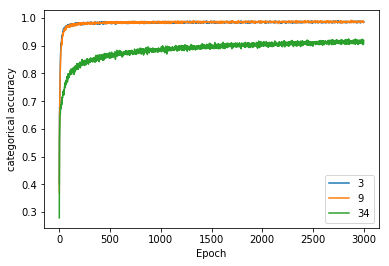

In [7]:
num = 3
n_trials = 5
EPOCHS = 3000
kernel_size_list = [3, 9, 34]
train_policy_network(num, kernel_size_list, n_trials, EPOCHS)

n = 8

In [8]:
n = 9
m = 8
l = 4

value_hand_nml = value_iteration(n, m, l, 0.9)
state_nml = generate_all_l(n, m, l)
hand_nml = generate_all_l(n, m - 1, l)
#print(len(hand_nml))
#print(hand_nml)
#print(value_hand_nml)

n = 34
max_value_discard_list, discard_state_nml = states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l)
#for i in max_value_discard_list: print(i) 
discard_hist_nml = states_to_hist(discard_state_nml, n)
discard_ans_vector_nml = np.array(discard_ans_prob_vector(max_value_discard_list, n, m, l))
#print(discard_ans_vector_nml)

iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 1, 32)         416       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 1, 32)         128       
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 1, 32)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 400)               410000    
_________________________________________________________________
dense_31 (Dense)             (None, 34)                13634     
Total params: 424,178
Trainable params: 424,114
Non-trainable params: 64
______________________________________________

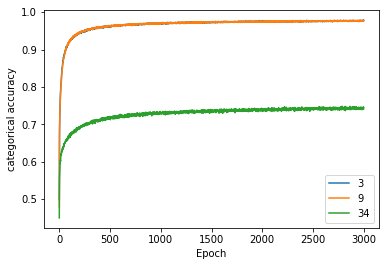

In [9]:
num = 3
n_trials = 5
EPOCHS = 3000
kernel_size_list = [3, 9, 34]
train_policy_network(num, kernel_size_list, n_trials, EPOCHS)